In [23]:
import numpy as np
import matplotlib.pyplot as plt

with open("data.txt") as f:
    content = f.read()

In [24]:
# jobs = np.array([[(2,1),(0,3),(1,6), (3,7), (5,3), (4,6)],
#                 [(1,8),(2,5),(4,10),(5,10),(0,10),(3,4)],
#                 [(2,5),(3,4),(5,8), (0,9), (1,1), (4,7)],
#                 [(1,5),(0,5),(2,5), (3,3), (4,8), (5,9)],
#                 [(2,9),(1,3),(4,5), (5,4), (0,3), (3,1)],
#                 [(1,3),(3,3),(5,9), (0,10),(4,4), (2,1)]])

data = content.split("\n")
jobs = []
for i in range(1, len(data)):
    line = [int(x) for x in data[i].split(" ")]
    dataline = []
    for j in range(line[0]):
        dataline.append((line[j * 3 + 2] - 1, line[j * 3 + 3]))
    jobs.append(dataline)
print(jobs)
jobs = np.array(jobs)

[[(2, 2), (0, 1), (1, 6), (3, 7), (5, 3), (4, 3)], [(1, 8), (2, 5), (4, 10), (5, 10), (0, 10), (3, 2)], [(2, 5), (3, 4), (5, 8), (0, 9), (1, 1), (4, 7)], [(1, 3), (0, 5), (2, 3), (3, 3), (4, 8), (5, 9)], [(2, 9), (1, 3), (4, 5), (5, 4), (0, 3), (3, 1)], [(1, 3), (3, 3), (5, 8), (0, 9), (4, 4), (2, 1)]]


In [25]:
def cost(schedule):
    j = len(jobs)
    m = len(jobs[0])

    tj = [0]*j
    tm = [0]*m

    ij = [0]*j

    for i in schedule:
        machine, time = jobs[i][ij[i]]
        ij[i] += 1

        start = max(tj[i], tm[machine])
        end = start + time
        tj[i] = end
        tm[machine] = end

    return max(tm)

In [26]:
def plot(schedule):
    
    j = len(jobs)
    m = len(jobs[0])

    tj = [0]*j
    tm = [0]*m

    ij = [0]*j
    
    output = []
    yticks = []
    yticklabels = []
    
    fig, gnt = plt.subplots()
     
    gnt.set_ylim(0, m * 10 + 20)
    gnt.set_xlim(0, cost(schedule))

    gnt.set_xlabel('seconds since start')
    gnt.set_ylabel('Machine')
    
    for i in range(m):
        output.append([])
        yticks.append(i* 10 + 15)
        yticklabels.append(str(i + 1))

    gnt.grid(True)
    gnt.set_yticks(yticks)
    gnt.set_yticklabels(yticklabels)


    for i in schedule:
        machine, time = jobs[i][ij[i]]
        ij[i] += 1
        start = max(tj[i], tm[machine])
        end = start + time
        tj[i] = end
        tm[machine] = end
        
        output[machine].append((start, time))
        
        
    for i in range(m):
        gnt.broken_barh(output[i], ((i+1) * 10, 9),
                                          facecolors =('tab:red'))

In [27]:
# 获取种群中最佳染色体
def getBest(chrs, view=False):
    best = 0
    bestCost = cost(chrs[best])
    for j in range(1, len(chrs)):
        c = cost(chrs[j])
        if (view and j % 10 == 0):
            print(c, end=' ')
        if (bestCost > c):
            best = j
            bestCost = c
    return chrs[best]

#初始化种群
def initChrs(n):
    chrs = []
    init = [i for i in range(len(jobs[0]))] * len(jobs)
    for i in range(n):
        temp = init.copy()
        np.random.shuffle(temp)
        chrs.append(temp)
    return chrs

In [28]:
#选择
def select(chrs, correction = 0):
    n = len(chrs)
    sum = 0
    possibility = []
    allDis = []
    for i in chrs:
        d = cost(i)
        allDis.append(d)
        sum += 1 / (d - correction)
        possibility.append(sum)

    childlen = round(len(chrs) * 0.45) * 2
    elitelen = len(chrs) - childlen
    sort = np.argsort(allDis)
    new_chrs = []
    elite_chrs = []


    for i in range(elitelen):
        elite_chrs.append(chrs[sort[i]].copy())
    
    for i in range(childlen):
        temp = np.random.random() * sum
        for j in range(n):
            if (temp < possibility[j]):
                new_chrs.append(chrs[j].copy())
                break
    return new_chrs, elite_chrs

def rein(chrs, elite_chrs):
    chrs.extend(elite_chrs)

In [29]:
#交叉(两点交叉)

def crossTwo(chr1, chr2):
    a, b = np.random.choice(range(len(chr1) + 1), 2, False)
    a, b = min(a, b), max(a, b)
    chr1[a: b], chr2[a: b] = chr2[a: b], chr1[a: b]
    
    n = len(jobs[0])
    for chr in (chr1, chr2):
        bincount = np.bincount(chr)
        indexing = []
        for i in range(n):
            indexing.append(np.where(np.array(chr) == i)[0].tolist())
        i = 0
        while (i < n):
            if (bincount[i] < n):
                for j in range(n):
                    if (bincount[j] > n):
                        chr[indexing[j][0]] = i
                        del indexing[j][0]
                        bincount[j] -= 1
                        break
                bincount[i] += 1
            else:
                i += 1
            
            
def cross(chrs, p):
    n = len(chrs)
    i = 0
    while (i < n):
        if (np.random.random() < p):
            crossTwo(chrs[i], chrs[i + 1])
        i += 2


In [30]:
#变异
def mutantSingle(chr):
    a, b = np.random.choice(range(len(chr)), 2, False)
    # a = np.random.randint(len(chr) - 1)
    # b = a + 1
    chr[a], chr[b] = chr[b], chr[a]
    
def mutant(chrs, p):
    for c in chrs:
        if (np.random.random() < p):
            mutantSingle(c)

In [31]:
#逆转
def reverseSingle(chr):
    a, b = np.random.choice(range(len(chr) + 1), 2, False)
    a, b = min(a, b), max(a, b)
    chr[a : b] = np.flip(chr[a : b], axis=0)
    
def reverse(chrs):
    for i in range(len(chrs)):
        temp = chrs[i].copy()
        reverseSingle(temp)
        if (cost(temp) < cost(chrs[i])):
            chrs[i] = temp

In [32]:
# m代数 vrate变异率 crate交叉率

m = 200
mrate = 0.05
crate = 0.9

allCost = [] #存储历代距离变化，

# 初始化种群
chrs = initChrs(100)

# best = getBest(chrs)
bestCost = cost (getBest(chrs))
        
allCost.append(bestCost)

view = False

for i in range(m):
    
    #选择
    chrs, elite_chrs = select(chrs, bestCost * 0.8)
    
    if (i % 10 == 9):
        print("\nThe " + str(i+1) + " Generation：", end='')
        view = True
    else:
        view = False
    bestCost = cost(getBest(chrs, view))
    allCost.append(bestCost)

    #交叉
    cross(chrs, crate)

    #变异
    mutant(chrs, mrate)

    #逆转
    reverse(chrs)

    #组合
    rein(chrs, elite_chrs)


The 10 Generation：77 69 58 58 87 75 58 58 
The 20 Generation：68 76 65 68 74 84 68 68 
The 30 Generation：54 54 54 67 76 58 54 54 
The 40 Generation：64 61 57 52 65 52 60 52 
The 50 Generation：52 55 52 52 52 52 55 52 
The 60 Generation：52 58 52 52 52 52 57 52 
The 70 Generation：52 52 52 52 61 52 52 55 
The 80 Generation：52 52 52 52 52 52 52 52 
The 90 Generation：52 52 52 52 52 52 52 52 
The 100 Generation：52 52 52 52 52 55 52 52 
The 110 Generation：52 52 52 52 52 52 52 56 
The 120 Generation：52 54 52 52 52 54 52 69 
The 130 Generation：52 52 63 52 86 52 52 52 
The 140 Generation：52 52 52 52 52 52 52 52 
The 150 Generation：61 52 52 52 52 52 52 52 
The 160 Generation：53 52 55 52 52 52 52 52 
The 170 Generation：52 51 52 52 51 52 51 52 
The 180 Generation：51 51 51 51 51 52 51 51 
The 190 Generation：51 51 51 51 51 51 51 51 
The 200 Generation：51 51 51 51 52 53 51 51 

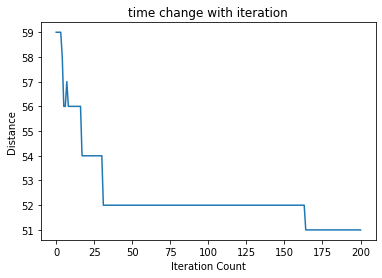

best time: 51


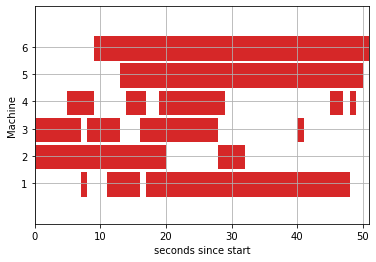

In [33]:
# 距离随温度变化
x = list(range(len(allCost)))
y = allCost
plt.title("time change with iteration")
plt.xlabel("Iteration Count")
plt.ylabel("Distance")
plt.plot(x,y)
plt.show()

best = getBest(chrs)
plot(best)
print("best time: " + str(cost(best)))